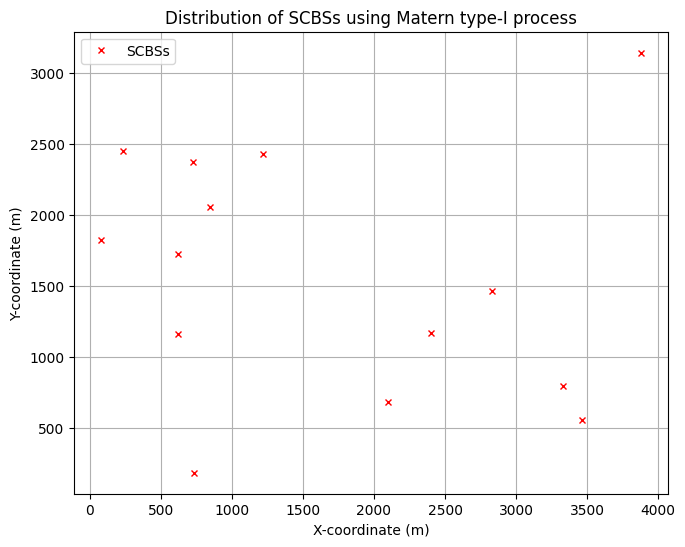

lambdaExactI =  7.381794437343685e-07
lambdaEmpI =  8.75e-07


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

plt.close('all')
np.random.seed(42)
# Simulation window parameters
areaTotal = 16e6  # area in square meters
xMin = 0
xMax = np.sqrt(areaTotal)
yMin = 0
yMax = np.sqrt(areaTotal)

# Parameters for the parent and daughter point processes
rho = 10e-5  # density of SCBSs per square meter
d_min_SCBS = 250  # minimum distance between SCBSs in meters

# Extended simulation windows parameters
radiusCore = d_min_SCBS / 2  # radius of hard core

# Arrays for collecting statistics
numbSim = 1
numbPointsAll = np.zeros(numbSim)  # number of SCBSs
numbPointsAll_I = np.zeros(numbSim)  # number of Matern I points

# Lists to store SCBSs coordinates
scbs_coordinates = []

# Loop through for each simulation
for ss in range(numbSim):
    # Calculate the expected number of SCBSs
    numbPoints = rho * np.exp(-rho * np.pi * radiusCore**2) * areaTotal
    numbPoints = int(np.random.poisson(numbPoints))  # Poisson number of SCBSs

    # Generate SCBSs coordinates using a Poisson point process
    xxPoissonExt = xMin + (xMax - xMin) * np.random.rand(numbPoints)
    yyPoissonExt = yMin + (yMax - yMin) * np.random.rand(numbPoints)

    # Removing/thinning points for Matern I
    booleRemoveI = np.zeros(numbPoints, dtype=bool)  # Index for removing points -- Matern I
    for ii in range(numbPoints):
        distTemp = np.hypot(xxPoissonExt[ii] - xxPoissonExt, yyPoissonExt[ii] - yyPoissonExt)  # Distances to other points
        booleInDisk = (distTemp < radiusCore) & (distTemp > 0)  # Check if inside disk

        # Matern I
        booleRemoveI[ii] = any(booleInDisk)

    # Remove points to generate Matern hard-core processes
    booleKeepI = ~(booleRemoveI)
    xxMaternI = xxPoissonExt[booleKeepI]
    yyMaternI = yyPoissonExt[booleKeepI]

    # Store SCBSs coordinates
    scbs_coordinates.extend(zip(xxMaternI, yyMaternI))

    # Update statistics
    numbPointsAll[ss] = numbPoints
    numbPointsAll_I[ss] = len(xxMaternI)

# Save SCBSs coordinates to CSV file
with open('tsbs_coordinates.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['X-coordinate', 'Y-coordinate'])
    for point in scbs_coordinates:
        writer.writerow(point)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(xxMaternI, yyMaternI, 'rx', markersize=5, label='SCBSs')
plt.xlabel('X-coordinate (m)')
plt.ylabel('Y-coordinate (m)')
plt.title('Distribution of SCBSs using Matern type-I process')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Compare statistics
areaWindow = areaTotal  # Area of simulation window

# Matern I
lambdaExactI = rho * np.exp(-rho * np.pi * radiusCore**2)  # Exact
print("lambdaExactI = ", lambdaExactI)
lambdaEmpI = np.mean(numbPointsAll_I / areaWindow)  # Empirical
print("lambdaEmpI = ", lambdaEmpI)


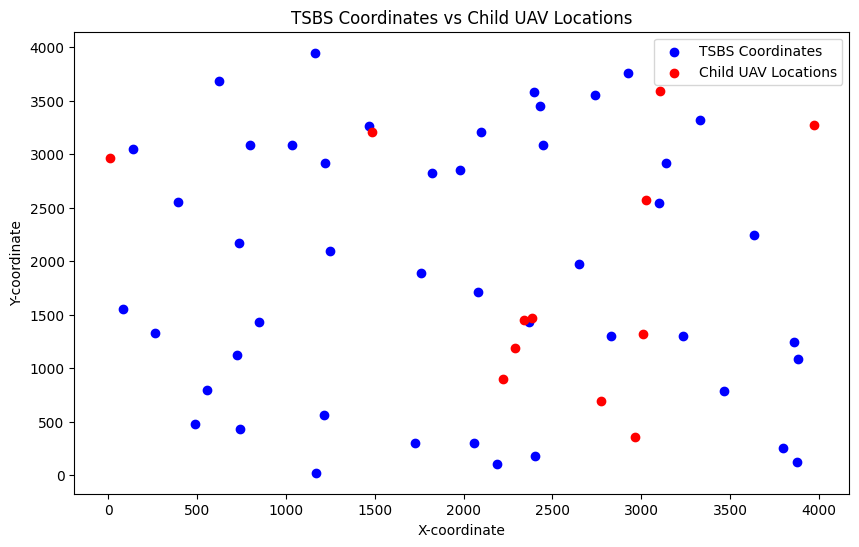

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Step 1: Read data from tsbs_coordinates.csv
df_tsbs = pd.read_csv("tsbs_coordinates.csv")

# Step 2: Generate random coordinates for 4 locations
random_coordinates = {
    "X-coordinate": [random.uniform(0, 4000) for _ in range(7)],
    "Y-coordinate": [random.uniform(0, 4000) for _ in range(7)]
}

# Step 3: Assign random altitudes to all coordinates
random_coordinates["altitude"] = [random.randint(300, 800) for _ in range(7)]

# Step 4: Write coordinates to child_uav_locations.csv
df_child_uav = pd.DataFrame(random_coordinates)
df_child_uav.to_csv("child_uav_locations.csv", index=False)

# Step 5: Plot both sets of coordinates
plt.figure(figsize=(10, 6))
plt.scatter(df_tsbs["X-coordinate"], df_tsbs["Y-coordinate"], label="TSBS Coordinates", color='blue')
plt.scatter(df_child_uav["X-coordinate"], df_child_uav["Y-coordinate"], label="Child UAV Locations", color='red')
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("CBS Coordinates vs Child UAV Locations")
plt.legend()
plt.grid(False)
plt.show()


<ipython-input-13-ebf0f18b8c4a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medoids['altitude'] = [random.randint(300, 800) for _ in range(k)]


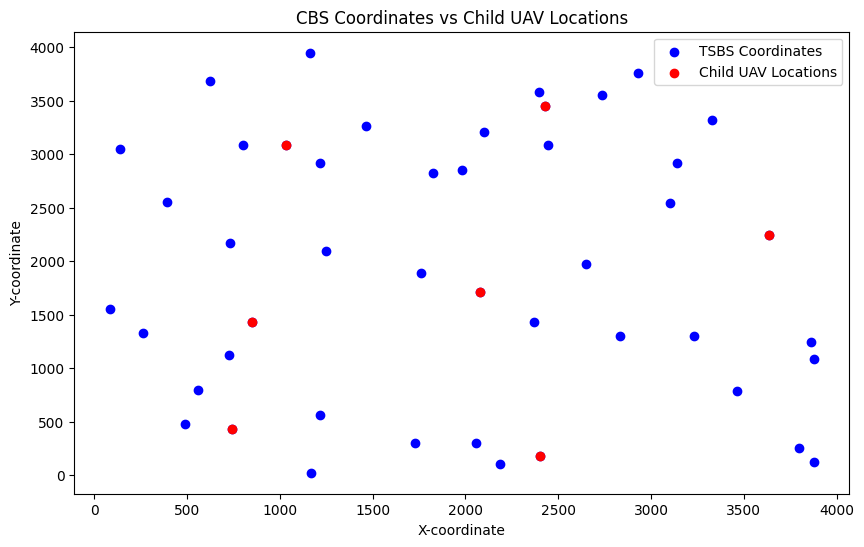

In [ ]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances_argmin_min

# Step 1: Preprocess the data (if needed)
df_tsbs = pd.read_csv("tsbs_coordinates.csv")

# Step 2: Implement k-medoids clustering
k = 7  # Number of clusters
kmedoids = KMedoids(n_clusters=k, random_state=42)
clusters = kmedoids.fit_predict(df_tsbs[['X-coordinate', 'Y-coordinate']])

# Step 3: Determine the optimal number of clusters (optional)

# Step 4: Assign cluster labels
df_tsbs['Cluster'] = clusters

# Step 5: Choose representatives (medoids)
medoid_indices, _ = pairwise_distances_argmin_min(kmedoids.cluster_centers_, df_tsbs[['X-coordinate', 'Y-coordinate']])
medoids = df_tsbs.iloc[medoid_indices]

# Step 6: Generate random altitudes for medoids
medoids['altitude'] = [random.randint(300, 800) for _ in range(k)]

# Step 7: Save the results
medoids.to_csv("child_uav_locations.csv", index=False)

# Step 8: Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df_tsbs["X-coordinate"], df_tsbs["Y-coordinate"], label="TSBS Coordinates", color='blue')
plt.scatter(medoids["X-coordinate"], medoids["Y-coordinate"], label="Child UAV Locations", color='red')
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("CBS Coordinates vs Child UAV Locations")
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS and child UAV locations from CSV files
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]

def load_child_uav_locations(child_uav_csv):
    child_uav_df = pd.read_csv(child_uav_csv)
    child_uav_df['uav_index'] = range(1, len(child_uav_df) + 1)
    return child_uav_df[['uav_index', 'X-coordinate', 'Y-coordinate', 'altitude']]

# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (2 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS  + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x)**2 + (tsbs_y - uav_y)**2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1/np.sqrt(2)) * (np.random.randn(1, N) + 1j*np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Load TSBS and child UAV locations
tsbs_csv = "tsbs_coordinates.csv"
child_uav_csv = "child_uav_locations.csv"

tsbs_locations = load_tsbs_locations(tsbs_csv)
child_uav_locations = load_child_uav_locations(child_uav_csv)

# Generate random data rate values
data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

# Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
channel_gain_data = []
for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
    for idx_uav, child_uav_row in child_uav_locations.iterrows():
        distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'], child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
        elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
        path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

        # Calculate fading in dB
        m = 1  # Shape parameter (m = 1 for Rayleigh fading)
        fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

        transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
        channel_gain = calculate_channel_gain()
        data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
        channel_gain_data.append((tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain, data_rate))

# Save results to CSV
with open('path_loss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])
    writer.writerows(channel_gain_data)


<ipython-input-14-04e74d19fdda>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-14-04e74d19fdda>:55: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load the channel_gain.csv file
channel_gain_df = pd.read_csv('path_loss.csv')

# Calculate the product of magnitude squared of channel gain and inverse of path-loss for each row
product_column = (channel_gain_df['channel_gain'] ** 2) / (channel_gain_df['path_loss'])

# Add the product column to the DataFrame
channel_gain_df['parameter'] = product_column

# Save the updated DataFrame to channel_gain.csv
channel_gain_df.to_csv('path_loss.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

# Load the path_loss.csv file
channel_gain_df = pd.read_csv('path_loss.csv')

# Convert parameter column from dB to watt
channel_gain_df['parameter'] = 10**(channel_gain_df['parameter'] / 10)

# Save the updated DataFrame to path_loss.csv
channel_gain_df.to_csv('path_loss.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

# Load the channel_gain.csv file
channel_gain_df = pd.read_csv('path_loss.csv')

# Convert interference threshold from watts to dBm
interference_threshold_dbm = 1.1943**-14  # Convert watts to dBm

# Calculate optimal power using the division of the 'product' column and interference threshold in dB
channel_gain_df['optimal_power'] = interference_threshold_dbm / channel_gain_df['parameter']

# Save the updated DataFrame to channel_gain.csv
channel_gain_df.to_csv('path_loss.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np

# Load the channel_gain.csv file
channel_gain_df = pd.read_csv('path_loss.csv')



# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m1,m2):
    z0 = np.abs(nakagami.rvs(m1, size=1))
    z1 = np.abs(nakagami.rvs(m1, size=1))
    z0=10*math.log10(z0)
    z1=10*math.log10(z1)
    return PLoS * z0 + PNLoS * z1

# Update the calculate_fading function to consider Nakagami distribution
def calculate_received_power(optimal_power, path_loss, PLoS, PNLoS, m1, m2):
    fading = calculate_fading(PLoS, PNLoS, m1, m2)
    received_power_dB = 10 * np.log10(optimal_power) + fading - path_loss
    # Convert received power from dB to watts
    return received_power_dB

# Define shape parameter 'm' for Nakagami distribution
m1 = 1  # For Rayleigh fading, set m = 1
m2 = 4

# Calculate received power in watts using the formula
channel_gain_df['received_power_dB'] = calculate_received_power(channel_gain_df['optimal_power'],
                                                                   channel_gain_df['path_loss'],
                                                                   channel_gain_df['PLoS'],
                                                                   channel_gain_df['PNLoS'],
                                                                   m1, m2)

# Save the updated DataFrame to channel_gain.csv
channel_gain_df.to_csv('path_loss.csv', index=False)

print("Received power column added to channel_gain.csv")


Received power column added to channel_gain.csv


<ipython-input-14-1095917c314a>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-14-1095917c314a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)


In [ ]:
import pandas as pd

# Define noise power in dBm
noise_power_dbm = -125  # Noise power in dBm

# Calculate SINR for each row
def calculate_sinr(received_power, interference_sum, noise_power):
    return received_power / (noise_power + interference_sum)

# Calculate interference sum for each row (sum of interference powers from other child-UAVs)
def calculate_interference_sum(channel_gain_df):
    interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
    return interference_sum

# Load channel_gain.csv into DataFrame
channel_gain_df = pd.read_csv('path_loss.csv')  # Assuming you have path_loss.csv in the current directory

# Calculate interference sum column
channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)

# Calculate SINR column
channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)

# Save the updated DataFrame to path_loss.csv
channel_gain_df.to_csv('path_loss.csv', index=False)

print("SINR column added to path_loss.csv")


SINR column added to path_loss.csv


In [ ]:
import pandas as pd
import numpy as np

# Load the path_loss.csv file
channel_gain_df = pd.read_csv('path_loss.csv')

# Calculate the bandwidth using the formula: data_rate / log2(1 + SINR)
bandwidth_column = channel_gain_df['data_rate'] / np.log2(1 + channel_gain_df['SINR'])

# Add the bandwidth column to the DataFrame
channel_gain_df['bandwidth'] = bandwidth_column

# Save the updated DataFrame to path_loss.csv
channel_gain_df.to_csv('path_loss.csv', index=False)


In [ ]:
import pandas as pd

# Load the path_loss.csv file
channel_gain_df = pd.read_csv('path_loss.csv')

# Calculate spectral efficiency using the formula: data_rate / bandwidth
spectral_efficiency_column = channel_gain_df['data_rate'] / channel_gain_df['bandwidth']

# Add the spectral efficiency column to the DataFrame
channel_gain_df['spectral_efficiency'] = spectral_efficiency_column

# Save the updated DataFrame to path_loss.csv
channel_gain_df.to_csv('path_loss.csv', index=False)


In [ ]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv("path_loss.csv")

# Find unique 'sbs_index' and 'uav_index'
unique_tsbs_index = df['tsbs_index'].unique()
unique_uav_index = df['uav_index'].unique()

# Initialize the matrix A with zeros
A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

# Minimum SINR threshold
min_sinr = -10

# Iterate over each unique 'sbs_index'
for tsbs_index in unique_tsbs_index:
    # Filter rows for the current 'sbs_index'
    tsbs_data = df[df['tsbs_index'] == tsbs_index]

    # Find the child-UAV providing maximum SINR
    max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
    max_sinr_uav_index = max_sinr_row['uav_index']
    max_sinr_value = max_sinr_row['SINR']

    # Check if SINR exceeds the minimum SINR threshold
    if max_sinr_value > min_sinr:
        A.loc[tsbs_index, max_sinr_uav_index] = 1

print("Matrix A:")
print(A)


Matrix A:
      1.0  2.0  3.0  4.0
1.0     0    0    1    0
2.0     0    1    0    0
3.0     0    0    1    0
4.0     0    0    1    0
5.0     0    1    0    0
6.0     0    1    0    0
7.0     0    1    0    0
8.0     0    0    1    0
9.0     0    0    1    0
10.0    0    1    0    0
11.0    1    0    0    0
12.0    0    0    1    0
13.0    0    0    1    0
14.0    0    0    1    0
15.0    0    1    0    0
16.0    0    0    1    0
17.0    0    1    0    0
18.0    0    0    1    0
19.0    0    1    0    0
20.0    0    0    1    0
21.0    0    0    1    0
22.0    0    1    0    0
23.0    0    1    0    0
24.0    0    1    0    0
25.0    0    1    0    0
26.0    0    1    0    0
27.0    0    1    0    0


In [ ]:
A_updated = A.copy()

max_bandwidth = 400  # MHz
max_links = 7  # Maximum number of links a UAV can accommodate

# Iterate over each child-UAV
for uav_index in unique_uav_index:
  # Initialize counters
  C_links = 0
  C_bandwidth = 0

  # Get data for the current child-UAV
  uav_data = df[df['uav_index'] == uav_index]

  # Filter rows where A is already 1 for the current UAV
  uav_data = uav_data[uav_data['tsbs_index'].isin(A_updated.index[A_updated[uav_index] == 1])]

  # Iterate over unique TSBS indices
  for tsbs_index in uav_data['tsbs_index'].unique():
      # Get data for the current TSBS index
      tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]

      # Sort the data for the current TSBS index by spectral efficiency
      tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

      # Iterate through the sorted data and allocate bandwidth
      for _, row in tsbs_data.iterrows():
          bandwidth = row['bandwidth']

          # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
          if C_bandwidth + bandwidth <= max_bandwidth and C_links < max_links:
              # Update counters
              C_links += 1
              C_bandwidth += bandwidth
          else:
              # If adding bandwidth exceeds the maximum allowed, set Aij to 0
              A_updated.loc[tsbs_index, uav_index] = 0

          # Check if the maximum number of links constraint is satisfied
          if C_links >= max_links:
              break

In [ ]:
F_s = 0

# Iterate over each TSBS
for tsbs_index in unique_tsbs_index:
    # Get data for the current TSBS
    tsbs_data = df[df['tsbs_index'] == tsbs_index]

    # Iterate over each child-UAV for the current TSBS
    for uav_index in unique_uav_index:
        # Check if the corresponding entry in the updated matrix is 1
        if A_updated.loc[tsbs_index, uav_index] == 1:
            # Get the data rate for the current TSBS and child-UAV
            data_rate = tsbs_data[tsbs_data['uav_index'] == uav_index]['data_rate'].values[0]

            # Add the product of data rate and corresponding entry in the updated matrix to the sum rate
            F_s += data_rate

print("F_s (Sum Rate):", F_s)

F_s (Sum Rate): 300


In [ ]:
# Initialize C' as the total number of associated TSBSs
C_prime = A_updated.sum().sum()

# Initialize Cb as the cumulative bandwidth used by associated TSBSs
C_b = (A_updated * df['bandwidth']).sum().sum()

# Initialize Fs as total sum-rate of associated TSBSs
Fs = F_s

# Initialize RB (required bandwidth) as 1.6 Gbps
RB = 1.6 * 1000  # Convert Gbps to Mbps

# Continue looping until Fs is less than or equal to RB
while Fs > RB:
    # Select child-UAV with max associated TSBSs
    max_tsbs_uav = A_updated.sum(axis=0).idxmax()

    # Select TSBS with minimum data rate demand
    min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
    min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
    min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

    # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
    A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
    C_prime -= 1
    Fs -= min_data_rate_data_rate
    C_b -= min_data_rate_tsbs['bandwidth']

    print(f"De-associated TSBS {min_data_rate_tsbs_index} from UAV {max_tsbs_uav}")
    print(f"Fs: {Fs} Mbps")

print("Final Matrix A:")
print(A_updated)


Final Matrix A:
      1.0  2.0  3.0  4.0
1.0     0    0    1    0
2.0     0    1    0    0
3.0     0    0    0    0
4.0     0    0    0    0
5.0     0    1    0    0
6.0     0    0    0    0
7.0     0    0    0    0
8.0     0    0    1    0
9.0     0    0    0    0
10.0    0    0    0    0
11.0    1    0    0    0
12.0    0    0    0    0
13.0    0    0    0    0
14.0    0    0    0    0
15.0    0    0    0    0
16.0    0    0    0    0
17.0    0    0    0    0
18.0    0    0    0    0
19.0    0    0    0    0
20.0    0    0    0    0
21.0    0    0    0    0
22.0    0    0    0    0
23.0    0    0    0    0
24.0    0    0    0    0
25.0    0    0    0    0
26.0    0    0    0    0
27.0    0    0    0    0
1291.5013644388741


In [ ]:
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami
from sklearn.cluster import KMeans

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS locations from CSV file
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]

# Generate child UAV locations using K-means clustering
def generate_child_uav_locations(tsbs_df, num_uavs):
    # Perform K-means clustering on TSBS locations to generate child UAV locations
    kmeans = KMeans(n_clusters=num_uavs, random_state=0)
    kmeans.fit(tsbs_df[['X-coordinate', 'Y-coordinate']])
    centroids = kmeans.cluster_centers_

    # Randomly assign altitudes in the range of 300 to 800
    altitudes = np.random.randint(300, 801, size=num_uavs)

    # Create DataFrame for child UAV locations
    child_uav_df = pd.DataFrame({'X-coordinate': centroids[:, 0],
                                 'Y-coordinate': centroids[:, 1],
                                 'altitude': altitudes})

    child_uav_df['uav_index'] = range(1, num_uavs + 1)
    child_uav_csv = 'child_uav_locations_process.csv'
    child_uav_df.to_csv(child_uav_csv, index=False)

    return child_uav_df[['uav_index', 'X-coordinate', 'Y-coordinate', 'altitude']]

# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (2 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x) ** 2 + (tsbs_y - uav_y) ** 2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1 / np.sqrt(2)) * (np.random.randn(1, N) + 1j * np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Load TSBS locations
tsbs_csv = "tsbs_coordinates.csv"
tsbs_locations = load_tsbs_locations(tsbs_csv)

# Varying max_bandwidth
for max_bandwidth in range(0, 401, 100):
    # Generate child UAV locations
    num_uavs = 2 # Number of UAVs equal to the number of TSBS
    child_uav_locations = generate_child_uav_locations(tsbs_locations, num_uavs)

    # Generate random data rate values
    data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

    # Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
    channel_gain_data = []
    for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
        for idx_uav, child_uav_row in child_uav_locations.iterrows():
            distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'],
                                          child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
            elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
            path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

            # Calculate fading in dB
            m = 1  # Shape parameter (m = 1 for Rayleigh fading)
            fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

            transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
            channel_gain = calculate_channel_gain()
            data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
            channel_gain_data.append(
                (tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain,
                 data_rate))

    # Save results to CSV
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    with open(path_loss_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])
        writer.writerows(channel_gain_data)

    print(f"Completed generation for max_bandwidth = {max_bandwidth}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-b613697d74f2>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-b613697d74f2>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-b613697d74f2>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 200


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-b613697d74f2>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 300


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-b613697d74f2>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 400


In [ ]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Max Bandwidth', 'Sum Rate (F_s)', 'Bandwidth Consumed', 'Number of 1s in A_updated'])

# Iterate over different max_bandwidth values
for max_bandwidth in range(0, 401, 100):
    # Load the path_loss.csv file for the current max_bandwidth
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    channel_gain_df = pd.read_csv(path_loss_csv)
    # Calculate the product of magnitude squared of channel gain and inverse of path-loss for each row
    product_column = (channel_gain_df['channel_gain'] ** 2) / (channel_gain_df['path_loss'])

    # Add the product column to the DataFrame
    channel_gain_df['parameter'] = product_column

    # Convert parameter column from dB to watt
    channel_gain_df['parameter'] = 10**(channel_gain_df['parameter'] / 10)

    # Convert interference threshold from watts to dBm
    interference_threshold_dbm = 1.1943**-14  # Convert watts to dBm

    # Calculate optimal power using the division of the 'product' column and interference threshold in dB
    channel_gain_df['optimal_power'] = interference_threshold_dbm / channel_gain_df['parameter']

    def calculate_fading(PLoS, PNLoS, m1,m2):
      z0 = np.abs(nakagami.rvs(m1, size=1))
      z1 = np.abs(nakagami.rvs(m1, size=1))
      z0=10*math.log10(z0)
      z1=10*math.log10(z1)
      return PLoS * z0 + PNLoS * z1

    # Update the calculate_fading function to consider Nakagami distribution
    def calculate_received_power(optimal_power, path_loss, PLoS, PNLoS, m1, m2):
        fading = calculate_fading(PLoS, PNLoS, m1, m2)
        received_power_dB = 10 * np.log10(optimal_power) + fading - path_loss
        # Convert received power from dB to watts
        return received_power_dB

    # Define shape parameter 'm' for Nakagami distribution
    m1 = 1  # For Rayleigh fading, set m = 1
    m2 = 4

    # Calculate received power in watts using the formula
    channel_gain_df['received_power_dB'] = calculate_received_power(channel_gain_df['optimal_power'],
                                                                      channel_gain_df['path_loss'],
                                                                      channel_gain_df['PLoS'],
                                                                      channel_gain_df['PNLoS'],
                                                                      m1, m2)
    noise_power_dbm = -125  # Noise power in dBm

    # Calculate SINR for each row
    def calculate_sinr(received_power, interference_sum, noise_power):
        return received_power / (noise_power + interference_sum)

    # Calculate interference sum for each row (sum of interference powers from other child-UAVs)
    def calculate_interference_sum(channel_gain_df):
        interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
        return interference_sum

    # Calculate interference sum column
    channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)

    # Calculate SINR column
    channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)
    # Calculate the bandwidth using the formula: data_rate / log2(1 + SINR)
    bandwidth_column = channel_gain_df['data_rate'] / np.log2(1 + channel_gain_df['SINR'])

    # Add the bandwidth column to the DataFrame
    channel_gain_df['bandwidth'] = bandwidth_column
    spectral_efficiency_column = channel_gain_df['data_rate'] / channel_gain_df['bandwidth']

    # Add the spectral efficiency column to the DataFrame
    channel_gain_df['spectral_efficiency'] = spectral_efficiency_column

    # Save the updated DataFrame to channel_gain.csv
    channel_gain_df.to_csv(path_loss_csv, index=False)


    # Load the data from the CSV file
    df = pd.read_csv(path_loss_csv)

    # Find unique 'sbs_index' and 'uav_index'
    unique_tsbs_index = df['tsbs_index'].unique()
    unique_uav_index = df['uav_index'].unique()

    # Initialize the matrix A with zeros
    A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

    # Minimum SINR threshold
    min_sinr = -10

    # Iterate over each unique 'sbs_index'
    for tsbs_index in unique_tsbs_index:
        # Filter rows for the current 'sbs_index'
        tsbs_data = df[df['tsbs_index'] == tsbs_index]

        # Find the child-UAV providing maximum SINR
        max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
        max_sinr_uav_index = max_sinr_row['uav_index']
        max_sinr_value = max_sinr_row['SINR']

        # Check if SINR exceeds the minimum SINR threshold
        if max_sinr_value > min_sinr:
            A.loc[tsbs_index, max_sinr_uav_index] = 1

    # Initialize the matrix A_updated with zeros
    A_updated = A.copy()

    # Initialize counters
    num_links_updated = 0
    C_bandwidth = 0

    max_links = 7

    # Iterate over each child-UAV
    for uav_index in unique_uav_index:
        existing_links = A_updated.index[A_updated[uav_index] == 1]

        # Get data for the current child-UAV
        uav_data = df[df['uav_index'] == uav_index]

        # Initialize counters
        C_bandwidth = 0
        num_links_updated = 0

        # Iterate through TSBSs until maximum resources are utilized
        for tsbs_index in uav_data['tsbs_index'].unique():
            # Filter data for the current tsbs_index and sort by spectral efficiency
            tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]
            tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

            # Iterate through sorted data
            for _, row in tsbs_data.iterrows():
                bandwidth = row['bandwidth']

                # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
                if C_bandwidth + bandwidth <= max_bandwidth and num_links_updated < max_links:
                    # Update matrix A and counters
                    if tsbs_index in existing_links:
                        A_updated.loc[tsbs_index, uav_index] = 1
                        C_bandwidth += bandwidth

                else:
                    # If adding bandwidth exceeds the maximum allowed, break the loop
                    A_updated.loc[tsbs_index, uav_index] = 0
                    break

    # Ensure each column (UAV) has no more than 7 ones (1s)
    for uav_index in unique_uav_index:
        column_sum = A_updated[uav_index].sum()
        if column_sum > max_links:
            # Find indices of extra ones and set them to zero
            extra_indices = A_updated.index[A_updated[uav_index] == 1][max_links:]
            A_updated.loc[extra_indices, uav_index] = 0


    # Calculate sum rate F_s
    F_s = 0
    for tsbs_index in unique_tsbs_index:
        for uav_index in unique_uav_index:
            if A_updated.loc[tsbs_index, uav_index] == 1:
                data_rate = df[(df['tsbs_index'] == tsbs_index) & (df['uav_index'] == uav_index)]['data_rate'].values[0]
                F_s += data_rate

    # Initialize C' as the total number of associated TSBSs
    C_prime = A_updated.sum().sum()

    # Initialize Cb as the cumulative bandwidth used by associated TSBSs
    C_b = (A_updated * df['bandwidth']).sum().sum()

    # Initialize Fs as total sum-rate of associated TSBSs
    Fs = F_s

    # Initialize RB (required bandwidth) as 1.6 Gbps
    RB = 1.6 * 1000  # Convert Gbps to Mbps

    # Continue looping until Fs is less than or equal to RB
    while Fs > RB:
        # Select child-UAV with max associated TSBSs
        max_tsbs_uav = A_updated.sum(axis=0).idxmax()

        # Select TSBS with minimum data rate demand
        min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
        min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
        min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

        # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
        A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
        C_prime -= 1
        Fs -= min_data_rate_data_rate
        C_b -= min_data_rate_tsbs['bandwidth']

    # Calculate the number of 1s in A_updated
    num_ones = A_updated.values.sum()

    # Append results to the results DataFrame
    results_df.loc[len(results_df)] = {'Max Bandwidth': max_bandwidth,
                                    'Sum Rate (F_s)': F_s,
                                    'Bandwidth Consumed': C_b,
                                    'Number of 1s in A_updated': num_ones}
# Save results to CSV
results_df.to_csv('results.csv', index=False)
print("Results saved to results.csv")


<ipython-input-10-d5fdca578a2a>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-10-d5fdca578a2a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)
<ipython-input-10-d5fdca578a2a>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-10-d5fdca578a2a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ext

Results saved to results.csv


<ipython-input-10-d5fdca578a2a>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-10-d5fdca578a2a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)


In [ ]:
!pip install scikit-learn-extra
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami
from sklearn_extra.cluster import KMedoids  # Import KMedoids for PAM
from sklearn.metrics import pairwise_distances_argmin_min

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS locations from CSV file
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]

# Generate child UAV locations using K-medoids clustering (PAM)
def generate_child_uav_locations(tsbs_df, num_uavs):
    # Convert TSBS coordinates to array
    tsbs_coordinates = tsbs_df[['X-coordinate', 'Y-coordinate']].values

    # Initialize K-medoids algorithm
    kmedoids = KMedoids(n_clusters=num_uavs, random_state=0)
    kmedoids.fit(tsbs_coordinates)

    # Get indices of chosen medoids and their coordinates
    medoid_indices = kmedoids.medoid_indices_
    medoid_coordinates = kmedoids.cluster_centers_

    # Randomly assign altitudes in the range of 300 to 800
    altitudes = np.random.randint(300, 801, size=num_uavs)

    # Create DataFrame for child UAV locations
    child_uav_df = pd.DataFrame({'X-coordinate': medoid_coordinates[:, 0],
                                 'Y-coordinate': medoid_coordinates[:, 1],
                                 'altitude': altitudes})

    child_uav_df['uav_index'] = range(1, num_uavs + 1)

    return child_uav_df[['uav_index', 'X-coordinate', 'Y-coordinate', 'altitude']]

# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (20 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x) ** 2 + (tsbs_y - uav_y) ** 2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1 / np.sqrt(2)) * (np.random.randn(1, N) + 1j * np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Load TSBS locations
tsbs_csv = "tsbs_coordinates.csv"
tsbs_locations = load_tsbs_locations(tsbs_csv)

# Varying max_bandwidth
for max_bandwidth in range(0, 401, 100):
    # Generate child UAV locations
    num_uavs = 7  # Number of UAVs equal to the number of TSBS
    child_uav_locations = generate_child_uav_locations(tsbs_locations, num_uavs)

    # Generate random data rate values
    data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

    # Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
    channel_gain_data = []
    tsbs_to_skip = set()  # To store tsbs_index with path_loss = 0
    for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
        tsbs_path_loss_zero = False  # Flag to track if path_loss is zero for this tsbs_index
        for idx_uav, child_uav_row in child_uav_locations.iterrows():
            distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'],
                                          child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
            elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
            path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

            # Check if path_loss is zero
            if path_loss_dB == 0:
                tsbs_path_loss_zero = True
                break  # No need to continue calculating for this tsbs_index

            # Calculate fading in dB
            m = 1  # Shape parameter (m = 1 for Rayleigh fading)
            fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

            transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
            channel_gain = calculate_channel_gain()
            data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
            channel_gain_data.append(
                (tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain,
                 data_rate))

        # If path_loss is zero for any UAV of this TSBS, mark tsbs_index for skipping
        if tsbs_path_loss_zero:
            tsbs_to_skip.add(tsbs_row['tsbs_index'])

    # Filter out data for tsbs_index with path_loss = 0
    channel_gain_data_filtered = [(tsbs_idx, uav_idx, path_loss, PLoS, PNLoS, ch_gain, data_rate)
                                  for tsbs_idx, uav_idx, path_loss, PLoS, PNLoS, ch_gain, data_rate in channel_gain_data
                                  if tsbs_idx not in tsbs_to_skip]

    # Save results to CSV
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    with open(path_loss_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])
        writer.writerows(channel_gain_data_filtered)

    print(f"Completed generation for max_bandwidth = {max_bandwidth}")


<ipython-input-13-c3d5c539d85a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-13-c3d5c539d85a>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 0


<ipython-input-13-c3d5c539d85a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-13-c3d5c539d85a>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 100


<ipython-input-13-c3d5c539d85a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-13-c3d5c539d85a>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 200


<ipython-input-13-c3d5c539d85a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-13-c3d5c539d85a>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 300


<ipython-input-13-c3d5c539d85a>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-13-c3d5c539d85a>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 400


In [ ]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Max Bandwidth', 'Sum Rate (F_s)', 'Bandwidth Consumed', 'Number of 1s in A_updated'])

# Iterate over different max_bandwidth values
for max_bandwidth in range(0, 401, 100):
    # Load the path_loss.csv file for the current max_bandwidth
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    channel_gain_df = pd.read_csv(path_loss_csv)
    # Calculate the product of magnitude squared of channel gain and inverse of path-loss for each row
    product_column = (channel_gain_df['channel_gain'] ** 2) / (channel_gain_df['path_loss'])

    # Add the product column to the DataFrame
    channel_gain_df['parameter'] = product_column

    # Convert parameter column from dB to watt
    channel_gain_df['parameter'] = 10**(channel_gain_df['parameter'] / 10)

    # Convert interference threshold from watts to dBm
    interference_threshold_dbm = 1.1943**-14  # Convert watts to dBm

    # Calculate optimal power using the division of the 'product' column and interference threshold in dB
    channel_gain_df['optimal_power'] = interference_threshold_dbm / channel_gain_df['parameter']

    def calculate_fading(PLoS, PNLoS, m1,m2):
      z0 = np.abs(nakagami.rvs(m1, size=1))
      z1 = np.abs(nakagami.rvs(m1, size=1))
      z0=10*math.log10(z0)
      z1=10*math.log10(z1)
      return PLoS * z0 + PNLoS * z1

    # Update the calculate_fading function to consider Nakagami distribution
    def calculate_received_power(optimal_power, path_loss, PLoS, PNLoS, m1, m2):
        fading = calculate_fading(PLoS, PNLoS, m1, m2)
        received_power_dB = 10 * np.log10(optimal_power) + fading - path_loss
        # Convert received power from dB to watts
        return received_power_dB

    # Define shape parameter 'm' for Nakagami distribution
    m1 = 1  # For Rayleigh fading, set m = 1
    m2 = 4

    # Calculate received power in watts using the formula
    channel_gain_df['received_power_dB'] = calculate_received_power(channel_gain_df['optimal_power'],
                                                                      channel_gain_df['path_loss'],
                                                                      channel_gain_df['PLoS'],
                                                                      channel_gain_df['PNLoS'],
                                                                      m1, m2)
    noise_power_dbm = -125  # Noise power in dBm

    # Calculate SINR for each row
    def calculate_sinr(received_power, interference_sum, noise_power):
        return received_power / (noise_power + interference_sum)

    # Calculate interference sum for each row (sum of interference powers from other child-UAVs)
    def calculate_interference_sum(channel_gain_df):
        interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
        return interference_sum

    # Calculate interference sum column
    channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)

    # Calculate SINR column
    channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)
    # Calculate the bandwidth using the formula: data_rate / log2(1 + SINR)
    bandwidth_column = channel_gain_df['data_rate'] / np.log2(1 + channel_gain_df['SINR'])

    # Add the bandwidth column to the DataFrame
    channel_gain_df['bandwidth'] = bandwidth_column
    spectral_efficiency_column = channel_gain_df['data_rate'] / channel_gain_df['bandwidth']

    # Add the spectral efficiency column to the DataFrame
    channel_gain_df['spectral_efficiency'] = spectral_efficiency_column

    # Save the updated DataFrame to channel_gain.csv
    channel_gain_df.to_csv(path_loss_csv, index=False)


    # Load the data from the CSV file
    df = pd.read_csv(path_loss_csv)

    # Find unique 'sbs_index' and 'uav_index'
    unique_tsbs_index = df['tsbs_index'].unique()
    unique_uav_index = df['uav_index'].unique()

    # Initialize the matrix A with zeros
    A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

    # Minimum SINR threshold
    min_sinr = -10

    # Iterate over each unique 'sbs_index'
    for tsbs_index in unique_tsbs_index:
        # Filter rows for the current 'sbs_index'
        tsbs_data = df[df['tsbs_index'] == tsbs_index]

        # Find the child-UAV providing maximum SINR
        max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
        max_sinr_uav_index = max_sinr_row['uav_index']
        max_sinr_value = max_sinr_row['SINR']

        # Check if SINR exceeds the minimum SINR threshold
        if max_sinr_value > min_sinr:
            A.loc[tsbs_index, max_sinr_uav_index] = 1

    # Initialize the matrix A_updated with zeros
    A_updated = A.copy()

    # Initialize counters
    num_links_updated = 0
    C_bandwidth = 0

    max_links = 7

    # Iterate over each child-UAV
    for uav_index in unique_uav_index:
        existing_links = A_updated.index[A_updated[uav_index] == 1]

        # Get data for the current child-UAV
        uav_data = df[df['uav_index'] == uav_index]

        # Initialize counters
        C_bandwidth = 0
        num_links_updated = 0

        # Iterate through TSBSs until maximum resources are utilized
        for tsbs_index in uav_data['tsbs_index'].unique():
            # Filter data for the current tsbs_index and sort by spectral efficiency
            tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]
            tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

            # Iterate through sorted data
            for _, row in tsbs_data.iterrows():
                bandwidth = row['bandwidth']

                # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
                if C_bandwidth + bandwidth <= max_bandwidth and num_links_updated < max_links:
                    # Update matrix A and counters
                    if tsbs_index in existing_links:
                        A_updated.loc[tsbs_index, uav_index] = 1
                        C_bandwidth += bandwidth

                else:
                    # If adding bandwidth exceeds the maximum allowed, break the loop
                    A_updated.loc[tsbs_index, uav_index] = 0
                    break

    # Ensure each column (UAV) has no more than 7 ones (1s)
    for uav_index in unique_uav_index:
        column_sum = A_updated[uav_index].sum()
        if column_sum > max_links:
            # Find indices of extra ones and set them to zero
            extra_indices = A_updated.index[A_updated[uav_index] == 1][max_links:]
            A_updated.loc[extra_indices, uav_index] = 0


    # Calculate sum rate F_s
    F_s = 0
    for tsbs_index in unique_tsbs_index:
        for uav_index in unique_uav_index:
            if A_updated.loc[tsbs_index, uav_index] == 1:
                data_rate = df[(df['tsbs_index'] == tsbs_index) & (df['uav_index'] == uav_index)]['data_rate'].values[0]
                F_s += data_rate

    # Initialize C' as the total number of associated TSBSs
    C_prime = A_updated.sum().sum()

    # Initialize Cb as the cumulative bandwidth used by associated TSBSs
    C_b = (A_updated * df['bandwidth']).sum().sum()

    # Initialize Fs as total sum-rate of associated TSBSs
    Fs = F_s

    # Initialize RB (required bandwidth) as 1.6 Gbps
    RB = 1.6 * 1000  # Convert Gbps to Mbps

    # Continue looping until Fs is less than or equal to RB
    while Fs > RB:
        # Select child-UAV with max associated TSBSs
        max_tsbs_uav = A_updated.sum(axis=0).idxmax()

        # Select TSBS with minimum data rate demand
        min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
        min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
        min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

        # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
        A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
        C_prime -= 1
        Fs -= min_data_rate_data_rate
        C_b -= min_data_rate_tsbs['bandwidth']

    # Calculate the number of 1s in A_updated
    num_ones = A_updated.values.sum()

    # Append results to the results DataFrame
    results_df.loc[len(results_df)] = {'Max Bandwidth': max_bandwidth,
                                    'Sum Rate (F_s)': F_s,
                                    'Bandwidth Consumed': C_b,
                                    'Number of 1s in A_updated': num_ones}
# Save results to CSV
results_df.to_csv('results_medoids.csv', index=False)
print("Results saved to results.csv")


<ipython-input-14-ce189ec2dabd>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-14-ce189ec2dabd>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)
<ipython-input-14-ce189ec2dabd>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-14-ce189ec2dabd>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ext

Results saved to results.csv
